Projet : Accident de la route
==============

## Etape 3 : Modélisation

### Import des données

In [1]:
# import des librairies
import pandas as pd
pd.set_option('display.max_columns', None)
pd.options.display.max_info_columns

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from lazypredict.supervised import LazyClassifier

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_selection import SelectKBest, f_classif, chi2
from sklearn.multiclass import OneVsRestClassifier
from sklearn.preprocessing import StandardScaler

from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import AdaBoostClassifier, RandomForestClassifier, ExtraTreesClassifier

from sklearn.metrics import confusion_matrix,classification_report, f1_score

import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter(action='ignore', category=FutureWarning)

In [2]:
# import du dataset
df = pd.read_csv("dataset/dataset_final.csv")
df.head()

,place,catu,grav,sexe,trajet,secu1,locp,catr,circ,nbv,vosp,prof,plan,surf,infra,situ,vma,lum,com,agg,int,atm,col,lat,long,senc,catv,obs,obsm,choc,manv,motor,age_group,h_group,weekday
0,1,1,1,1,5,1,-1,4,2,2,0,1,1,1,0,1,50,1,26198,2,3,1,3,44.56,4.73,1,3,0,2,1,9,1,2,6,2
1,1,1,0,1,5,1,-1,4,2,2,0,1,1,1,0,1,50,1,26198,2,3,1,3,44.56,4.73,1,6,0,2,2,1,1,7,6,2
2,1,1,1,1,9,1,0,4,2,2,0,1,1,1,0,1,50,1,25204,2,3,1,3,46.93,6.35,2,6,0,2,8,15,1,4,3,3
3,1,1,0,1,4,1,0,4,2,2,0,1,1,1,0,1,50,1,25204,2,3,1,3,46.93,6.35,2,5,0,2,1,1,1,6,3,3
4,1,1,0,1,0,1,-1,3,-1,2,0,1,1,1,5,1,50,1,22360,2,6,1,2,48.49,-2.76,2,6,0,2,1,2,1,3,6,3


### Séparation des données

In [3]:
X_train, X_test, y_train, y_test = train_test_split(df.drop(["grav"], axis=1), df.grav, test_size=0.2)
print("Séparation des labels et targets :", X_train.shape, X_test.shape, y_train.shape, y_test.shape)

Séparation des labels et targets : (365142, 34) (91286, 34) (365142,) (91286,)


In [4]:
# standardisation
scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

### Modélisation

Matrice de confusion :
 [[30592  7746]
 [ 9220 43728]]


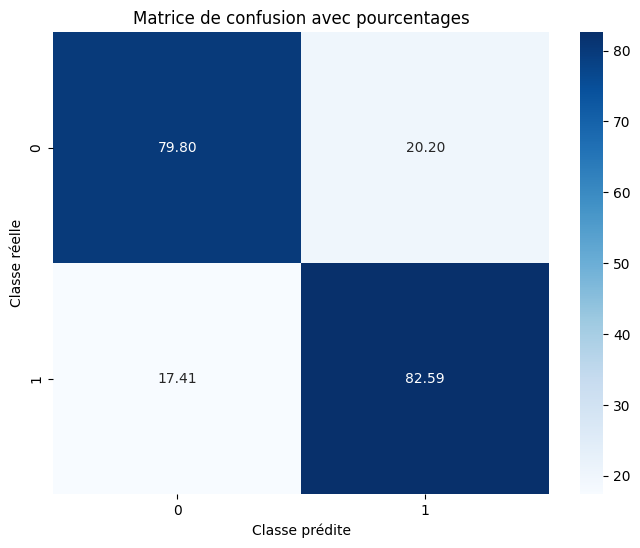

In [6]:
# model baseline
model = RandomForestClassifier(random_state=42).fit(X_train_scaled, y_train)
y_pred_rf_1 = model.predict(X_test_scaled)

cm_rf_1 = confusion_matrix(y_test, y_pred_rf_1)
print("Matrice de confusion :\n", cm_rf_1)

row_sums_rf_1 = cm_rf_1.sum(axis = 1)
cm_percent_rf_1 = (cm_rf_1.T / row_sums_rf_1).T * 100

plt.figure(figsize=(8, 6))
sns.heatmap(cm_percent_rf_1, annot = True, fmt = ".2f", cmap = "Blues")
plt.xlabel('Classe prédite')
plt.ylabel('Classe réelle')
plt.title('Matrice de confusion avec pourcentages')
plt.show();

Fitting 5 folds for each of 84 candidates, totalling 420 fits
[CV 4/5] END criterion=gini, max_depth=9, n_estimators=100;, score=0.814 total time= 1.6min
[CV 2/5] END criterion=gini, max_depth=9, n_estimators=100;, score=0.818 total time= 1.6min
[CV 3/5] END criterion=gini, max_depth=9, n_estimators=100;, score=0.815 total time= 1.6min
[CV 1/5] END criterion=gini, max_depth=9, n_estimators=100;, score=0.815 total time= 1.6min
[CV 5/5] END criterion=gini, max_depth=9, n_estimators=100;, score=0.817 total time= 1.6min
[CV 5/5] END criterion=gini, max_depth=9, n_estimators=150;, score=0.816 total time= 2.4min
[CV 4/5] END criterion=gini, max_depth=9, n_estimators=150;, score=0.815 total time= 2.4min
[CV 1/5] END criterion=gini, max_depth=9, n_estimators=150;, score=0.815 total time= 2.4min
[CV 3/5] END criterion=gini, max_depth=9, n_estimators=150;, score=0.815 total time= 2.4min
[CV 2/5] END criterion=gini, max_depth=9, n_estimators=150;, score=0.817 total time= 2.5min
[CV 2/5] END crite

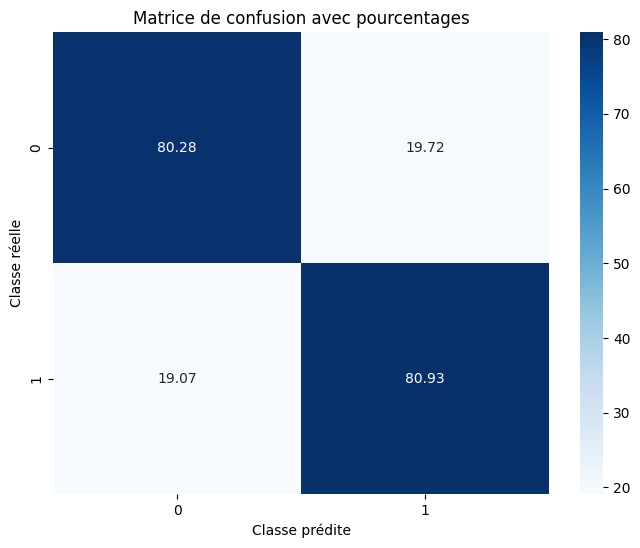

In [7]:
# model n°1

hp_rf = {
    'n_estimators': [100, 150, 200, 250],                      # Nombre d'estimateurs
    'criterion' :['gini', 'entropy', 'log_loss'],   # fonction de mesure de la qualité d'une scission
    'max_depth' :[9, 10, 11, 12, 13, 14, 15]                          # profondeur maximale de l'arbre
}

gs_rf= GridSearchCV(estimator=RandomForestClassifier(random_state=42),
                     param_grid=hp_rf,
                           cv = 5,  # Nombre de folds pour la validation croisée
                           verbose = 3, # Affiche le degré de détail des calculs
                           refit=True, # réentraine le modèle avec toutes les données
                           scoring="f1",
                           n_jobs = -1)  # Utiliser tous les coeurs du CPU

gs_rf.fit(X_train_scaled, y_train)

best_hp_rf = gs_rf.best_params_
best_score_rf = gs_rf.best_score_
best_estimator_rf = gs_rf.best_estimator_

print("Meilleurs paramètres trouvés:", best_hp_rf)
print("Meilleur score de validation croisée:", best_score_rf)

y_pred_rf = best_estimator_rf.predict(X_test_scaled)

cm_rf = confusion_matrix(y_test, y_pred_rf)
print("Matrice de confusion :\n", cm_rf)

row_sums_rf = cm_rf.sum(axis = 1)
cm_percent_rf = (cm_rf.T / row_sums_rf).T * 100

plt.figure(figsize=(8, 6))
sns.heatmap(cm_percent_rf, annot = True, fmt = ".2f", cmap = "Blues")
plt.xlabel('Classe prédite')
plt.ylabel('Classe réelle')
plt.title('Matrice de confusion avec pourcentages')
plt.show();

In [22]:
importances = best_estimator_rf.feature_importances_

feature_names = X_train.columns
importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

importance_df

,Feature,Importance
27,obsm,0.29
25,catv,0.11
29,manv,0.11
28,choc,0.05
21,col,0.05
22,lat,0.04
5,locp,0.04
26,obs,0.04
1,catu,0.03
2,sexe,0.03


### Modélisation après recherche des meilleures variables

Séparation des labels et targets : (365142, 15) (91286, 15) (365142,) (91286,)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/home/yu/workspace/acc_route/env_acc_route/lib/python3.10/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/home/yu/workspace/acc_route/env_acc_route/lib/python3.10/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/home/yu/workspace/acc_route/env_acc_route/lib/python3.10/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/home/yu/workspace/acc_route/env_acc_route/lib/python3.10/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is depr

[CV 5/5] END algorithm=SAMME.R, learning_rate=0.01, n_estimators=600;, score=0.773 total time= 6.5min


/home/yu/workspace/acc_route/env_acc_route/lib/python3.10/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


[CV 3/5] END algorithm=SAMME.R, learning_rate=0.01, n_estimators=600;, score=0.777 total time= 6.5min


/home/yu/workspace/acc_route/env_acc_route/lib/python3.10/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


[CV 4/5] END algorithm=SAMME.R, learning_rate=0.01, n_estimators=600;, score=0.771 total time= 6.9min


/home/yu/workspace/acc_route/env_acc_route/lib/python3.10/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


[CV 1/5] END algorithm=SAMME.R, learning_rate=0.01, n_estimators=600;, score=0.775 total time= 7.0min


/home/yu/workspace/acc_route/env_acc_route/lib/python3.10/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


[CV 2/5] END algorithm=SAMME.R, learning_rate=0.01, n_estimators=600;, score=0.775 total time= 7.0min


/home/yu/workspace/acc_route/env_acc_route/lib/python3.10/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


[CV 4/5] END algorithm=SAMME.R, learning_rate=0.01, n_estimators=700;, score=0.772 total time= 7.6min


/home/yu/workspace/acc_route/env_acc_route/lib/python3.10/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


[CV 3/5] END algorithm=SAMME.R, learning_rate=0.01, n_estimators=700;, score=0.779 total time= 7.8min


/home/yu/workspace/acc_route/env_acc_route/lib/python3.10/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


[CV 1/5] END algorithm=SAMME.R, learning_rate=0.01, n_estimators=700;, score=0.777 total time= 8.1min


/home/yu/workspace/acc_route/env_acc_route/lib/python3.10/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


[CV 5/5] END algorithm=SAMME.R, learning_rate=0.01, n_estimators=700;, score=0.774 total time= 8.2min


/home/yu/workspace/acc_route/env_acc_route/lib/python3.10/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


[CV 2/5] END algorithm=SAMME.R, learning_rate=0.01, n_estimators=700;, score=0.777 total time= 8.2min


/home/yu/workspace/acc_route/env_acc_route/lib/python3.10/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


[CV 2/5] END algorithm=SAMME.R, learning_rate=0.01, n_estimators=800;, score=0.785 total time= 8.9min


/home/yu/workspace/acc_route/env_acc_route/lib/python3.10/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


[CV 1/5] END algorithm=SAMME.R, learning_rate=0.01, n_estimators=800;, score=0.783 total time= 9.0min


/home/yu/workspace/acc_route/env_acc_route/lib/python3.10/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


[CV 1/5] END algorithm=SAMME.R, learning_rate=0.1, n_estimators=600;, score=0.811 total time= 7.5min


/home/yu/workspace/acc_route/env_acc_route/lib/python3.10/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


[CV 2/5] END algorithm=SAMME.R, learning_rate=0.1, n_estimators=600;, score=0.812 total time= 7.5min


/home/yu/workspace/acc_route/env_acc_route/lib/python3.10/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


[CV 3/5] END algorithm=SAMME.R, learning_rate=0.1, n_estimators=600;, score=0.813 total time= 7.4min


/home/yu/workspace/acc_route/env_acc_route/lib/python3.10/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


[CV 4/5] END algorithm=SAMME.R, learning_rate=0.1, n_estimators=600;, score=0.807 total time= 7.3min


/home/yu/workspace/acc_route/env_acc_route/lib/python3.10/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


[CV 5/5] END algorithm=SAMME.R, learning_rate=0.1, n_estimators=600;, score=0.810 total time= 7.4min


/home/yu/workspace/acc_route/env_acc_route/lib/python3.10/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


[CV 4/5] END algorithm=SAMME.R, learning_rate=0.01, n_estimators=800;, score=0.780 total time= 9.8min


/home/yu/workspace/acc_route/env_acc_route/lib/python3.10/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


[CV 3/5] END algorithm=SAMME.R, learning_rate=0.01, n_estimators=800;, score=0.785 total time=10.1min
[CV 1/5] END algorithm=SAMME.R, learning_rate=0.1, n_estimators=700;, score=0.812 total time= 8.5min
[CV 5/5] END algorithm=SAMME.R, learning_rate=0.01, n_estimators=800;, score=0.782 total time= 9.8min
[CV 2/5] END algorithm=SAMME.R, learning_rate=0.1, n_estimators=700;, score=0.813 total time= 8.7min
[CV 3/5] END algorithm=SAMME.R, learning_rate=0.1, n_estimators=700;, score=0.814 total time= 8.3min
[CV 4/5] END algorithm=SAMME.R, learning_rate=0.1, n_estimators=700;, score=0.808 total time= 8.5min
[CV 5/5] END algorithm=SAMME.R, learning_rate=0.1, n_estimators=700;, score=0.812 total time= 5.9min
[CV 1/5] END algorithm=SAMME.R, learning_rate=0.1, n_estimators=800;, score=0.813 total time= 6.4min
[CV 3/5] END algorithm=SAMME.R, learning_rate=0.1, n_estimators=800;, score=0.815 total time= 6.1min
[CV 2/5] END algorithm=SAMME.R, learning_rate=0.1, n_estimators=800;, score=0.815 total t

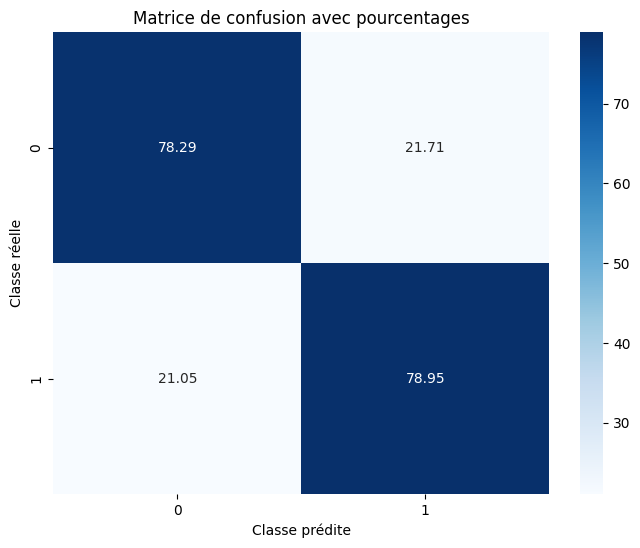

In [27]:
X = df.drop(['trajet','age_group', 'long', 'motor', 'vosp', 'lum', 'agg', 'com', 'situ','grav', 'infra', 'surf', 'plan', 'circ', 'atm', 'senc', 'int', 'prof', 'nbv', 'weekday'], axis=1)
y = df.grav

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
print("Séparation des labels et targets :", X_train.shape, X_test.shape, y_train.shape, y_test.shape)

# standardisation
scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

hp_ada = {
    'n_estimators': [600, 700, 800],        # Nombre de classificateurs faibles
    'learning_rate': [0.01, 0.1],     # Taux d'apprentissage : ajuste la contribution de chaque classificateur faible à la prédiction finale
    'algorithm': ['SAMME.R']      # Algorithme utilisé; 'SAMME.R' deprecied
}

dtc = DecisionTreeClassifier(random_state=42, max_depth=1)

gs_ada= GridSearchCV(estimator=AdaBoostClassifier(random_state=42, estimator=dtc),
                     param_grid=hp_ada,
                           cv = 5,  # Nombre de folds pour la validation croisée
                           verbose = 3, # Affiche le degré de détail des calculs
                           refit=True, # réentraine le modèle avec toutes les données
                           scoring="f1",
                           n_jobs = -1)  # Utiliser tous les coeurs du CPU

gs_ada.fit(X_train_scaled, y_train)

best_hp_ada = gs_ada.best_params_
best_score_ada = gs_ada.best_score_
best_estimator_ada = gs_ada.best_estimator_

print("Meilleurs paramètres trouvés:", best_hp_ada)
print("Meilleur score de validation croisée:", best_score_ada)

y_pred_ada = best_estimator_ada.predict(X_test_scaled)

cm_ada = confusion_matrix(y_test, y_pred_ada)
print("Matrice de confusion :\n", cm_ada)

row_sums_ada = cm_ada.sum(axis = 1)
cm_percent_ada = (cm_ada.T / row_sums_ada).T * 100

plt.figure(figsize=(8, 6))
sns.heatmap(cm_percent_ada, annot = True, fmt = ".2f", cmap = "Blues")
plt.xlabel('Classe prédite')
plt.ylabel('Classe réelle')
plt.title('Matrice de confusion avec pourcentages')
plt.show()

### Sauvegarde du modèle

In [31]:
import joblib

# Sauvegarder le modèle
joblib.dump(best_estimator_ada, 'best_estimator_ada_model.joblib')

['best_estimator_ada_model.joblib']

### Analyse des résultats

In [29]:
# création d'un df pour ajouter les prédictions au dataset
df_filtered = df.iloc[:len(y_test)]  

df_filtered['pred_ada'] = y_pred_ada
df_filtered.head()

,place,catu,grav,sexe,trajet,secu1,locp,catr,circ,nbv,vosp,prof,plan,surf,infra,situ,vma,lum,com,agg,int,atm,col,lat,long,senc,catv,obs,obsm,choc,manv,motor,age_group,h_group,weekday,pred_ada
0,1,1,1,1,5,1,-1,4,2,2,0,1,1,1,0,1,50,1,26198,2,3,1,3,44.56,4.73,1,3,0,2,1,9,1,2,6,2,0
1,1,1,0,1,5,1,-1,4,2,2,0,1,1,1,0,1,50,1,26198,2,3,1,3,44.56,4.73,1,6,0,2,2,1,1,7,6,2,1
2,1,1,1,1,9,1,0,4,2,2,0,1,1,1,0,1,50,1,25204,2,3,1,3,46.93,6.35,2,6,0,2,8,15,1,4,3,3,1
3,1,1,0,1,4,1,0,4,2,2,0,1,1,1,0,1,50,1,25204,2,3,1,3,46.93,6.35,2,5,0,2,1,1,1,6,3,3,0
4,1,1,0,1,0,1,-1,3,-1,2,0,1,1,1,5,1,50,1,22360,2,6,1,2,48.49,-2.76,2,6,0,2,1,2,1,3,6,3,0


In [30]:
# création d'un df qui affiche toutes les prédictions qui ne sont pas identiques au réel
df_mismatch = df_filtered[df_filtered['grav'] != df_filtered['pred_ada']]
df_mismatch.head()

,place,catu,grav,sexe,trajet,secu1,locp,catr,circ,nbv,vosp,prof,plan,surf,infra,situ,vma,lum,com,agg,int,atm,col,lat,long,senc,catv,obs,obsm,choc,manv,motor,age_group,h_group,weekday,pred_ada
0,1,1,1,1,5,1,-1,4,2,2,0,1,1,1,0,1,50,1,26198,2,3,1,3,44.56,4.73,1,3,0,2,1,9,1,2,6,2,0
1,1,1,0,1,5,1,-1,4,2,2,0,1,1,1,0,1,50,1,26198,2,3,1,3,44.56,4.73,1,6,0,2,2,1,1,7,6,2,1
6,1,1,0,2,0,1,-1,4,1,1,0,2,1,1,0,1,30,1,16102,2,3,8,6,45.69,-0.33,2,6,0,1,3,16,1,3,6,3,1
9,1,1,1,2,0,1,-1,3,2,2,0,1,1,1,0,1,80,1,13103,1,1,1,2,43.68,5.09,0,6,0,2,1,2,1,3,4,2,0
10,1,1,0,1,4,1,0,3,3,4,0,1,1,1,0,1,50,1,13056,2,2,1,3,43.41,5.05,1,5,0,1,3,15,1,4,5,3,1
